<a href="https://colab.research.google.com/github/t108368071/MyProject/blob/master/5_ann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive 
import numpy as np 

drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Colab Notebooks/

df_all = pd.read_csv("org_train_normal_new.csv") 
#num_features = ['cardiac_period', 'SUT', 'DT', 'DW_10', 'DW_25', 'DW_33', 'DW_50', 'DW_66','DW_75', 'SW_10 + DW_10', 'SW_10/DW_10', 'SW_25 + DW_25', 'SW_25/DW_25', 'SW_33 + DW_33', 'SW_33/DW_33','SW_50 + DW_50', 'SW_50 / DW_50', 'SW_66 + DW_66', 'SW_66 / DW_66','SW_75 + DW_75', 'SW_75 / DW_75','area','area_s','area_d']

#正常特徵
num_features = ['cardiac_period', 'SUT', 'DT','SW_25 + DW_25','SW_75 + DW_75','DW_50','SW_50 + DW_50','area_d']

#高血壓特徵
#num_features = ['cardiac_period','DT','area_d','area_s','SW_50 + DW_50','DW_33','SW_33/DW_33','SW_10/DW_10']

#低血壓特徵
#num_features = ['cardiac_period','DT','area_d','area_s','SUT','area','SW_10/DW_10','SW_25/DW_25']

#混和特徵
#num_features = ['cardiac_period','SUT', 'DT','DW_50','SW_75 / DW_75','area_d','DW_75', 'SW_10/DW_10']

target = ['systolic','diastolic']

df = df_all[num_features + target]
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks


,cardiac_period,SUT,DT,SW_25 + DW_25,SW_75 + DW_75,DW_50,SW_50 + DW_50,area_d,systolic,diastolic
0,105,23,81,41,22,19,31,0.962940,127.141203,61.299351
1,105,27,78,60,23,22,36,1.065357,126.555074,60.664378
2,79,25,54,71,20,12,28,0.687476,126.945827,73.510377
3,112,18,74,37,18,20,29,0.766506,133.295561,68.625967
4,79,23,58,41,23,18,31,0.843464,127.629645,66.134917


In [ ]:
df_target = pd.DataFrame(df, columns=["systolic", "diastolic"])
df.drop(["systolic", "diastolic"], axis=1, inplace=True)
df_target.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,systolic,diastolic
0,127.141203,61.299351
1,126.555074,60.664378
2,126.945827,73.510377
3,133.295561,68.625967
4,127.629645,66.134917


In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split  
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout,BatchNormalization
from keras.callbacks import EarlyStopping
from keras import optimizers

X_train, X_val, y_train, y_val = train_test_split(df, df_target, test_size=0.15, random_state=3)

print(len(X_train))
print(len(X_val))

10127
1788


In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X=StandardScaler()
x_train=sc_X.fit_transform(X_train)
x_val=sc_X.transform(X_val)

In [ ]:
from keras.callbacks import ReduceLROnPlateau
callbacks = []
callbacks.append(ReduceLROnPlateau(monitor="val_loss", verbose=1, factor=0.1,min_delta=0.0001,patience=30))
callbacks.append(EarlyStopping(monitor="val_loss", verbose=1, patience=120, restore_best_weights=True)) #patience=20

In [ ]:
model = Sequential()

model.add(Dense(128,input_dim=8,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(256,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32,kernel_initializer='normal',activation='relu'))
model.add(BatchNormalization())

model.add(Dense(2,activation='relu'))

opt = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=opt)
model.summary()

history=model.fit(x_train, y_train, epochs=1000, batch_size=32, validation_data=(x_val,y_val),shuffle=True,callbacks=callbacks)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 128)               1152      
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 128)               512       
_________________________________________________________________
dense_33 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
dense_34 (Dense)             (None, 32)               

MAE SBP: 5.415813227718572 SD:16.812699626297942 MAE DBP: 3.251816411938233 SD:4.665729533666363


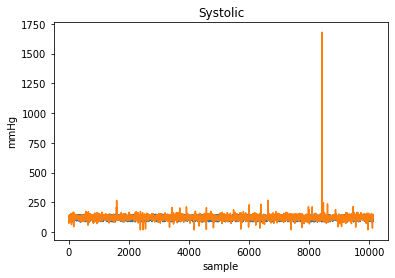

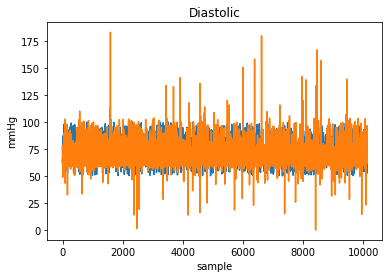

In [ ]:
prediction = model.predict(x_train)

error_sbp = prediction[:,0] - y_train["systolic"].values
error_dbp = prediction[:,1] - y_train["diastolic"].values

from sklearn.metrics import mean_absolute_error
mae_error_sbp = mean_absolute_error(prediction[:,0],y_train["systolic"].values)
mae_error_dbp = mean_absolute_error(prediction[:,1],y_train["diastolic"].values)

error_sbp_std = np.std(abs(prediction[:,0] - y_train["systolic"].values))
error_dbp_std = np.std(abs(prediction[:,1] - y_train["diastolic"].values))

print(f"MAE SBP: {mae_error_sbp} SD:{error_sbp_std} MAE DBP: {mae_error_dbp} SD:{error_dbp_std}")

sbp = np.vstack(y_train["systolic"])
dbp = np.vstack(y_train["diastolic"])
prd_sbp = np.vstack(prediction[:,0])
prd_dbp = np.vstack(prediction[:,1])

plt.figure(1)
plt.title("Systolic")
plt.xlabel("sample") 
plt.ylabel("mmHg") 
plt.plot(sbp)
plt.plot(prd_sbp)

plt.figure(2)
plt.title("Diastolic")
plt.xlabel("sample") 
plt.ylabel("mmHg") 
plt.plot(dbp)
plt.plot(prd_dbp)

In [ ]:
np.savetxt('kmeans_ann_normal.csv',np.column_stack((sbp,dbp,prd_sbp,prd_dbp,error_sbp,error_dbp)),delimiter=',')

In [ ]:
rf_org_test = pd.read_csv("rf_choice_nor_new.csv") 

#num_features = ['cardiac_period', 'SUT', 'DT', 'DW_10', 'DW_25', 'DW_33', 'DW_50', 'DW_66','DW_75', 'SW_10 + DW_10', 'SW_10/DW_10', 'SW_25 + DW_25', 'SW_25/DW_25', 'SW_33 + DW_33', 'SW_33/DW_33','SW_50 + DW_50', 'SW_50 / DW_50', 'SW_66 + DW_66', 'SW_66 / DW_66','SW_75 + DW_75', 'SW_75 / DW_75','area','area_s','area_d']

#正常特徵
#num_features = ['cardiac_period', 'SUT', 'DT','SW_25 + DW_25','SW_75 + DW_75','DW_50','SW_50 + DW_50','area_d']
#num_features = ['area_s','area','SW_10/DW_10','SW_66 + DW_66','SW_10 + DW_10','SW_50 + DW_50','SW_33 + DW_33','SW_33/DW_33']
#num_features = ['SW_25/DW_25','SW_66 / DW_66','DW_75','SW_75 / DW_75','DW_10','DW_33','DW_66','DW_25']

#高血壓特徵
#num_features = ['cardiac_period','DT','area_d','area_s','SW_50 + DW_50','DW_33','SW_33/DW_33','SW_10/DW_10']

#低血壓特徵
num_features = ['cardiac_period','DT','area_d','area_s','SUT','area','SW_10/DW_10','SW_25/DW_25']

#混和特徵
#num_features = ['cardiac_period','SUT', 'DT','DW_50','SW_75 / DW_75','area_d','DW_75', 'SW_10/DW_10']

#target = ['systolic']
target = ['systolic','diastolic']

rf_test = rf_org_test[num_features + target]
rf_test.head()

,cardiac_period,DT,area_d,area_s,SUT,area,SW_10/DW_10,SW_25/DW_25,systolic,diastolic
0,81,57,0.738714,0.388192,25,1.148528,0.645161,0.620690,89.873152,54.363488
1,110,75,1.075011,0.540700,32,1.640544,0.510204,0.578947,126.066633,62.813518
2,97,46,0.658115,0.360109,27,1.040184,0.459459,0.583333,131.879081,65.744164
3,99,71,0.985032,0.395535,24,1.404227,0.444444,0.500000,107.847782,87.528635
4,101,76,0.765067,0.389408,28,1.174757,0.564103,0.606061,110.045767,61.055130


In [ ]:
rf_test_target = pd.DataFrame(rf_test, columns=["systolic", "diastolic"])
rf_test.drop(["systolic", "diastolic"], axis=1, inplace=True)
rf_test_target.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,systolic,diastolic
0,89.873152,54.363488
1,126.066633,62.813518
2,131.879081,65.744164
3,107.847782,87.528635
4,110.045767,61.055130


In [ ]:
rf_test_pd=sc_X.transform(rf_test)

MAE SBP: 503.48997817027373 SD:297.6836496742082 MAE DBP: 66.23158162445301 SD:7.803319901570113


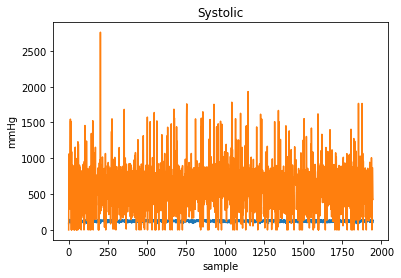

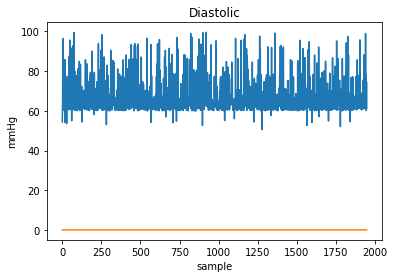

In [ ]:
rfprediction = model.predict(rf_test_pd)

error_sbp = rfprediction[:,0] - rf_test_target["systolic"].values
error_dbp = rfprediction[:,1] - rf_test_target["diastolic"].values

from sklearn.metrics import mean_absolute_error
mae_error_sbp = mean_absolute_error(rfprediction[:,0],rf_test_target["systolic"].values)
mae_error_dbp = mean_absolute_error(rfprediction[:,1],rf_test_target["diastolic"].values)

error_sbp_std = np.std(abs(rfprediction[:,0] - rf_test_target["systolic"].values))
error_dbp_std = np.std(abs(rfprediction[:,1] - rf_test_target["diastolic"].values))

print(f"MAE SBP: {mae_error_sbp} SD:{error_sbp_std} MAE DBP: {mae_error_dbp} SD:{error_dbp_std}")

sbp = np.vstack(rf_test_target["systolic"])
dbp = np.vstack(rf_test_target["diastolic"])
prd_sbp = np.vstack(rfprediction[:,0])
prd_dbp = np.vstack(rfprediction[:,1])

plt.figure(1)
plt.title("Systolic")
plt.xlabel("sample") 
plt.ylabel("mmHg") 
plt.plot(sbp)
plt.plot(prd_sbp)

plt.figure(2)
plt.title("Diastolic")
plt.xlabel("sample")
plt.ylabel("mmHg") 
plt.plot(dbp)
plt.plot(prd_dbp)